<a href="https://colab.research.google.com/github/roguxivlo/machine-learning-24L/blob/main/hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Working with Other Loss Functions**

-------------------------------

During the class today, we reconstructed an **ellipse**. The ellipse was defined with two **foci** and $C$ (the sum of distances of the ellipse points from the foci).

To reconstruct the ellipse through optimization, we began with **$N$ points** scattered randomly in the 2D plane. Our goal was to adjust their positions so that they satisfy the elliptical constraint as closely as possible. We achieved this by minimizing the **error-related loss**, $L^{(2)}_{\text{ellipse}}$ which was defined in today's class with $\ell_2$ norm as:

$$
L^{(2)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \epsilon_i^2
$$

where
$$
 \epsilon_i = d_{i1} + d_{i2} - C
$$
where $N$ is the number of points, and $d_{i1}, d_{i2}$ are their distances to the two foci.

In the homework assignment you will experiment with 3 other loss definitions based on some other possible norms.



1. $\ell_0$ norm resulting in
  $$
  L^{(0)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\epsilon_i \neq 0)
  $$
  - If you actually succeed to code this loss function, the question for you to answer in relation to $L^{(0)}_{\text{ellipse}}$ is why the training is not progressing with passing epochs.
  - If you actually fail to code this loss function, the question for you to answer is to explain the failure and reason out theoretically, why the training would not be progressing with passing epochs, anyway.

1. $\ell_1$ norm resulting in
  $$
  L^{(1)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(1)}_{\text{ellipse}}$ is why the training loss doesn't converge, even after the ellipse has been fully drawn.

1. $\ell_\infty$ norm resulting in
  $$
  L^{(\infty)}_{\text{ellipse}} =  \max_{i} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(\infty)}_{\text{ellipse}}$ is why the training takes so long and it doesn't converge in the end, either.

## **Points to Note**

1. Draw both the shape that the points draw as they move, and the loss value after each epoch, just as we did in class today.

2. Note, that the purpose of this excercise is not that you reconstruct a perfect ellipse, but rather that you give it a try, and even if you fail you should document and explain the failure, and answer a question related to a given loss definition.

3. You can also play around with the learning rate to try to improve convergence.

## **Task & Deliverables**
  
   - Document your experiments (python code and charts) and **write down your conclusions** into the Colab notebook.
   - It is not strictly required, but **if you make a movie showing the optimization progress it will be considered a strong point of your solution**
     - You can make a movie programmatically as we did in clustering class (our second class) with EM clustering,
     - or, you can save to disk the image files with epoch charts and use an external tool to bind them into a movie. Provide links to movie files in the README.
   - Place the Colab notebook  with the solution in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook (and any movies you created) and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.

## Sample code

   You can use the sample code provided below:



In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_results(epoch, trajectories, focus1, focus2, num_points, loss_history=None ):
    if loss_history is not None:
      fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    else:
      fig, axes = plt.subplots(1, 1, figsize=(6, 6))
      axes = [axes]

    points = np.array([trajectories[i][-1] for i in range(num_points)])
    # Left plot: Scatter of points with trajectories
    axes[0].scatter(points[:, 0], points[:, 1], label=f'Points - Epoch {epoch}')
    f1 = focus1.detach().cpu().numpy()
    f2 = focus2.detach().cpu().numpy()
    axes[0].scatter([f1[0], f2[0]], [f1[1], f2[1]], color='red', marker='x', s=100, label='Foci')

    # Draw movement traces
    for i in range(num_points):
        trajectory = np.array(trajectories[i])
        axes[0].plot(trajectory[:, 0], trajectory[:, 1], color='gray', linestyle='-', linewidth=0.5)

    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()


    axes[0].grid()

    if loss_history is not None:
      axes[0].set_title(f'Points after Epoch {epoch}')
      # Right plot: Loss history
      axes[1].plot(loss_history, color='blue')
      axes[1].set_xlabel("Epoch")
      axes[1].set_ylabel("Loss")
      axes[1].set_title("Loss Convergence")
      axes[1].grid()
    else:
      axes[0].set_title(f'Points before Epoch {epoch}')

    plt.show()

In [28]:
def train_with_loss(loss_function,
                    num_epochs=1000,
                    device="cuda",
                    use_scheduler=False,
                    ):

    # Fix the random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Define ellipse parameters
    focus1 = torch.tensor([-2.0, 0.0], device=device)  # First focus
    focus2 = torch.tensor([2.0, 0.0] , device=device)   # Second focus
    constant_sum = 6.0  # The sum of distances to the two foci

    # Initialize random 2D points from uniform distribution
    num_points = 100
    points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5]
    points = points.to(device)
    points.requires_grad = True

    # Reset trajectories
    trajectories = [[] for _ in range(num_points)]
    loss_history = []


    import time
    # Start timing
    start_time = time.time()
    # Define optimizer
    optimizer = torch.optim.Adam([points], lr=0.1)
    scheduler = None
    if (use_scheduler):
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Compute distances to both foci
        dist1 = torch.norm(points - focus1, dim=1)
        dist2 = torch.norm(points - focus2, dim=1)

        # Add epsilon vector as in problem statement:
        epsilon = dist1 + dist2 - constant_sum

        # Compute loss - it is implemented as MSE loss related to l_2 norm
        # TODO: your job is to replace the line below
        # with l_0, l_1 and l_infty - related loss
        loss = loss_function(epsilon)

        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()

        loss_history.append(loss.item())

        # Store current positions for tracking movement
        for i in range(num_points):
            trajectories[i].append(points[i].detach().cpu().clone().numpy())

        # Plot results every 10th epoch
        if epoch % 200 == 0:
            plot_results(epoch, trajectories, focus1, focus2, num_points, loss_history)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

    # End timing
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    #Final plot
    plot_results(epoch, trajectories, focus1, focus2, num_points, loss_history)

    return trajectories


def L2_loss(epsilon):
    return torch.mean((epsilon ** 2))

def L1_loss(epsilon):
    return torch.mean(torch.abs(epsilon))

def L0_loss(epsilon):
    return torch.mean(torch.where(epsilon != 0, 1.0, 0.0))

def L_infty_loss(epsilon):
    return torch.max(torch.abs(epsilon))


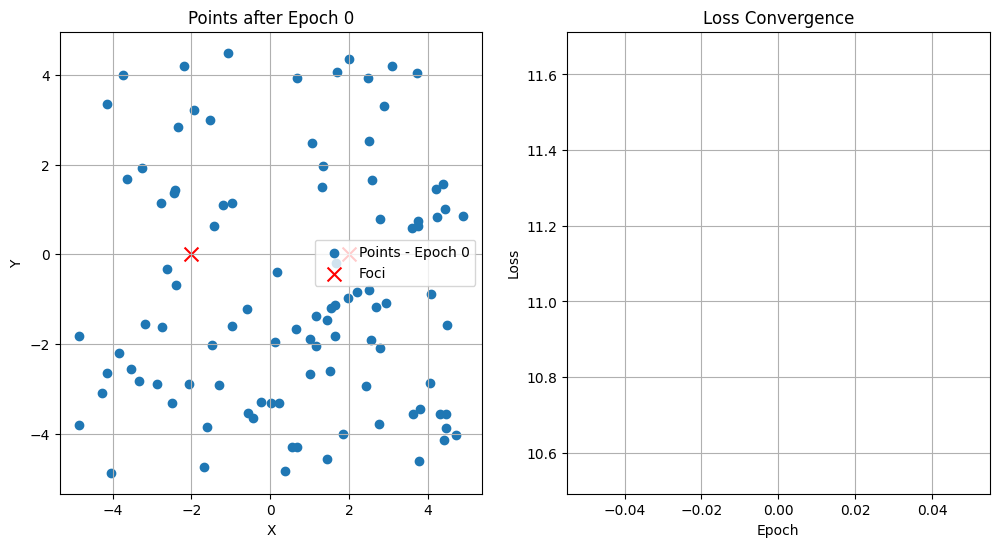

Epoch 0: Loss = 11.102330
Epoch 100: Loss = 0.000153


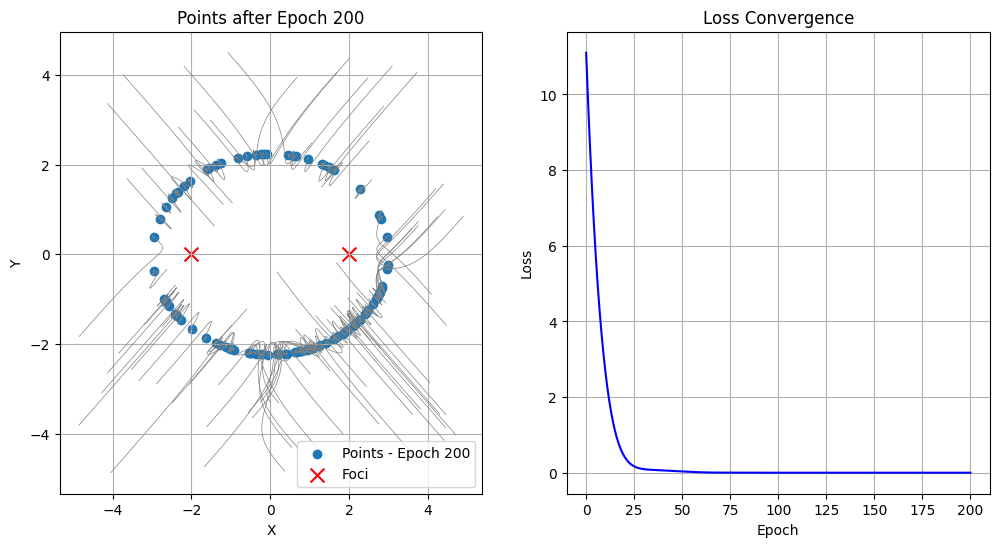

Epoch 200: Loss = 0.000000
Epoch 300: Loss = 0.000000


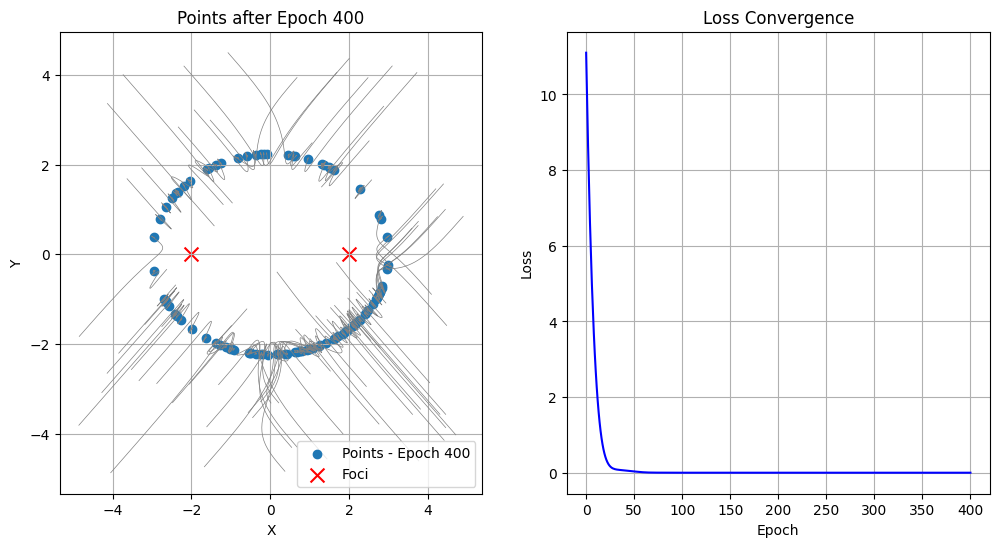

Epoch 400: Loss = 0.000000
Epoch 500: Loss = 0.000000


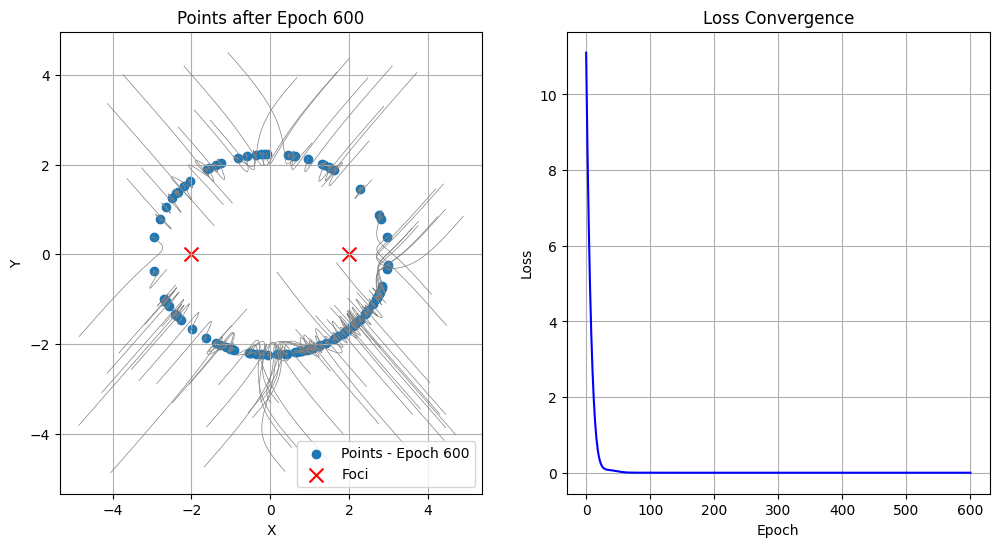

Epoch 600: Loss = 0.000000
Epoch 700: Loss = 0.000000


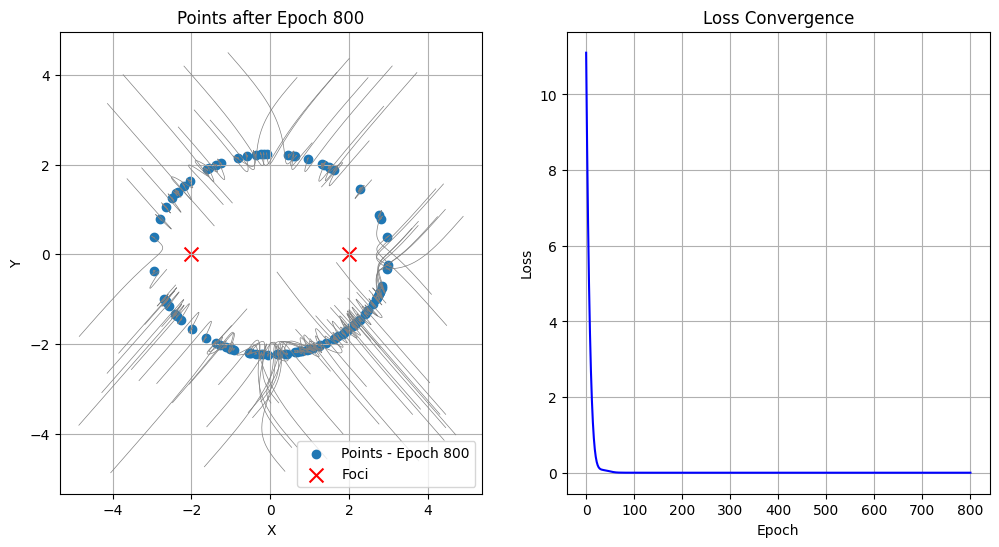

Epoch 800: Loss = 0.000000
Epoch 900: Loss = 0.000000
Elapsed time: 8.30740737915039 seconds


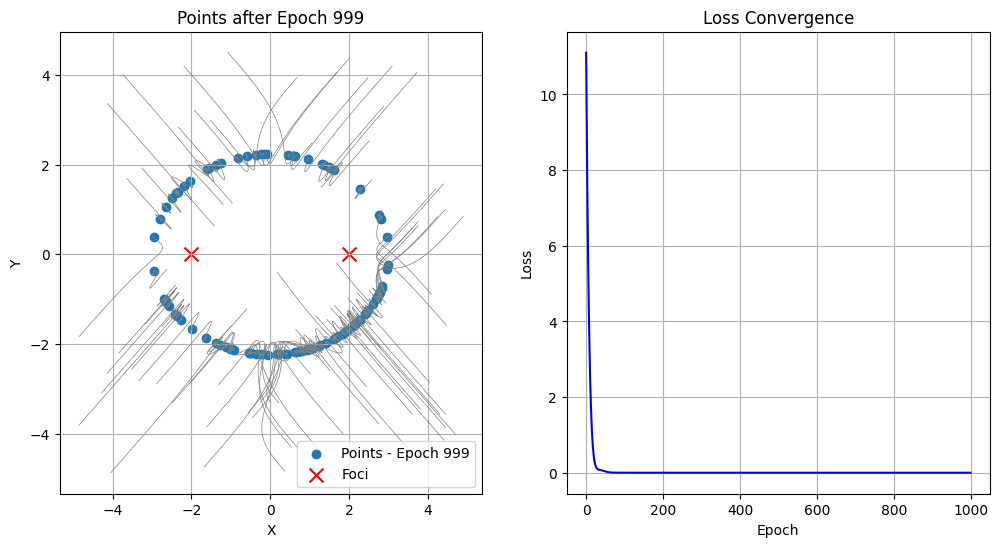

In [29]:
# Benchmark training for L_2 loss functions

trajectories_L2 = train_with_loss(L2_loss)

In [30]:
train_with_loss(L0_loss)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Why does $L^{(0)}_\text{ellipse}$ function fail?

Because it's derivative with respect to point coordinates is equal to $0$ (or does not exist at all). Therefore, we either cannot compute the gradient (where $\epsilon=0$), or it's equal to $0$ so no update in gradient descent would occur.



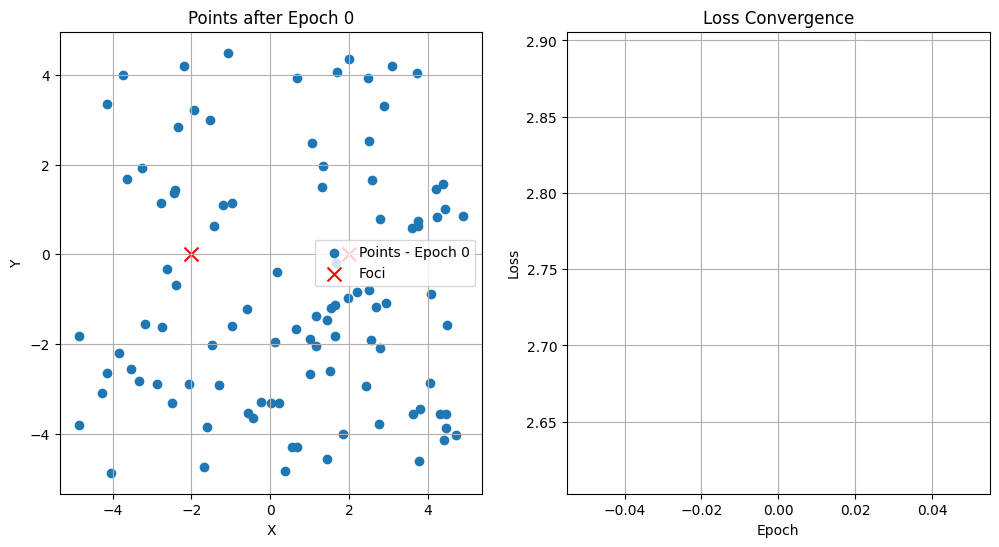

Epoch 0: Loss = 2.754212
Epoch 100: Loss = 0.024422


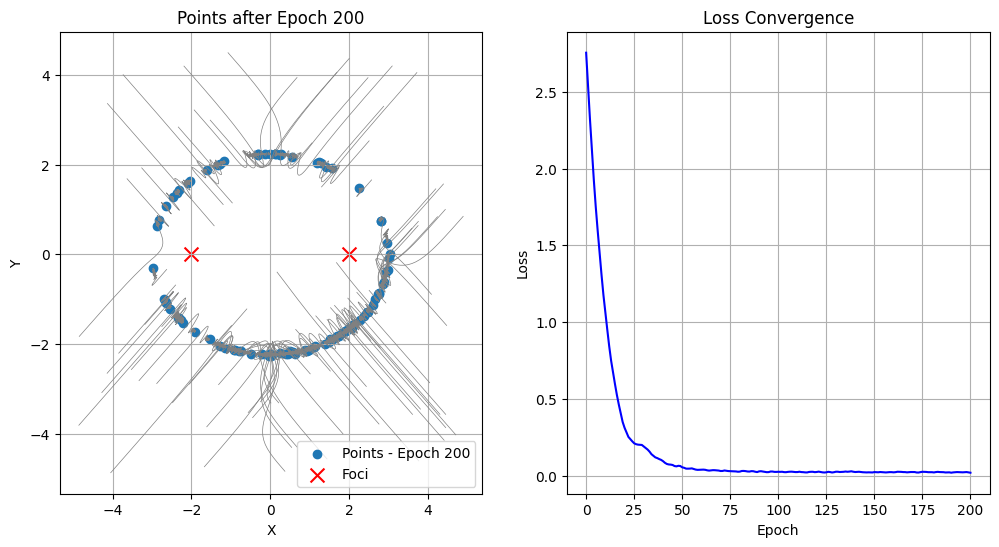

Epoch 200: Loss = 0.018269
Epoch 300: Loss = 0.021560


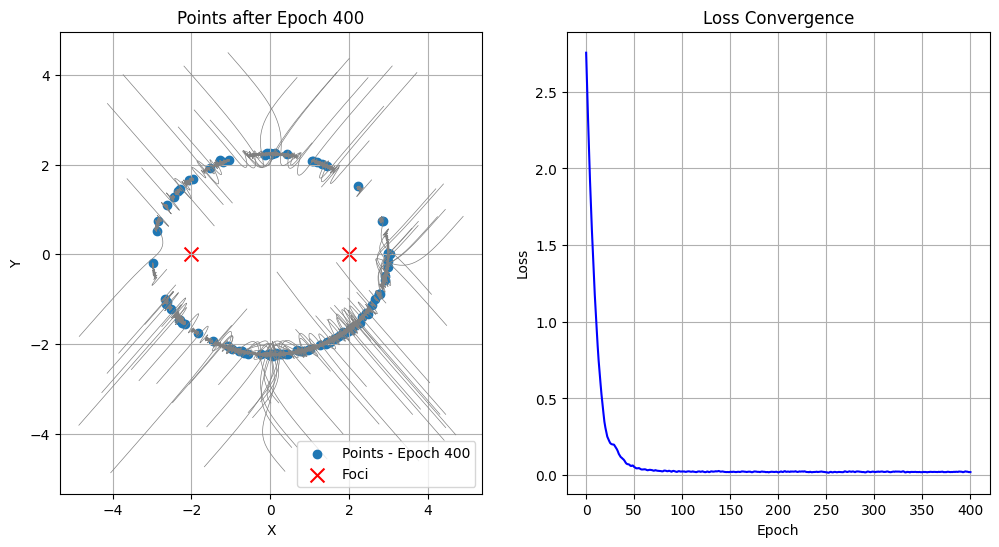

Epoch 400: Loss = 0.020092
Epoch 500: Loss = 0.023394


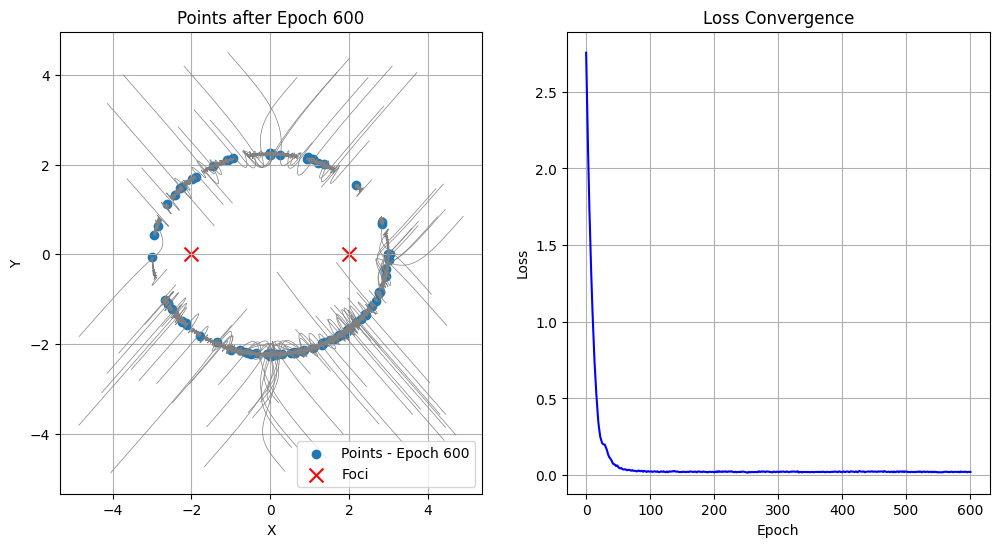

Epoch 600: Loss = 0.021364
Epoch 700: Loss = 0.021358


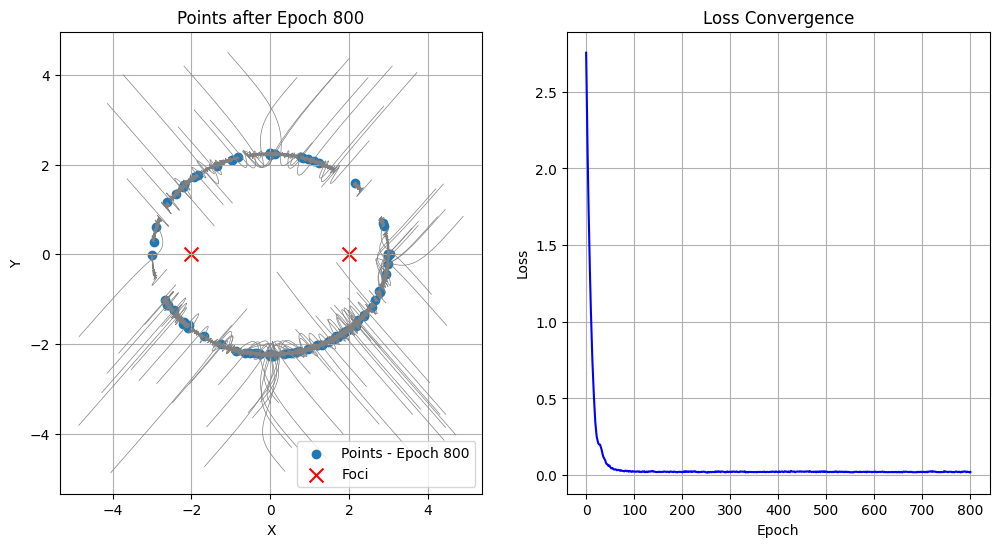

Epoch 800: Loss = 0.020856
Epoch 900: Loss = 0.021423
Elapsed time: 8.39302396774292 seconds


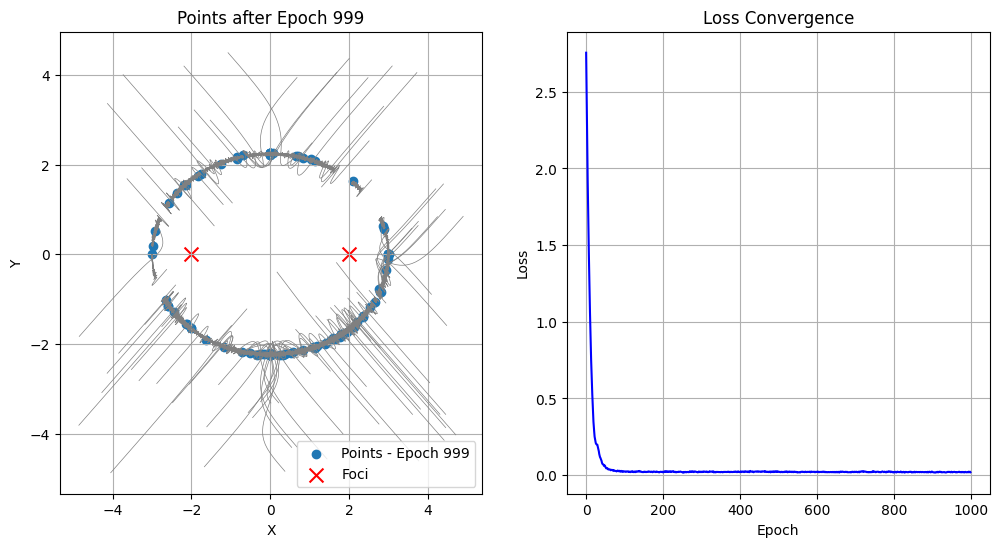

In [31]:
trajectories_L1 = train_with_loss(L1_loss)

We can observe that although an ellipse is being drawn - the loss doesn't converge to $0$.

Initial guess: gradient is always $\pm1$ (or doesn't exists: at $0$), hence we overshoot the minimum with too big learning rate.
Possible solution is to add a scheduler decaying learning rate along the way:

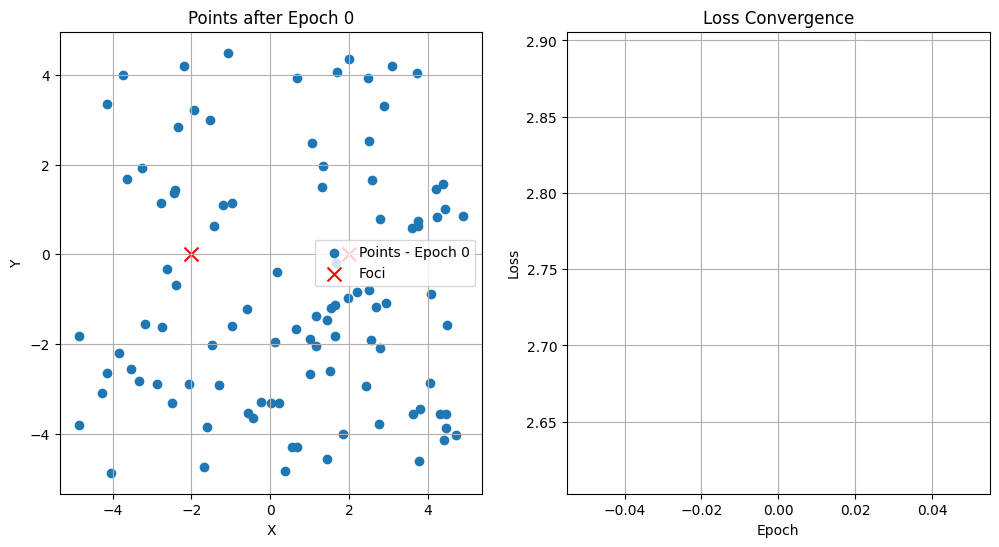

Epoch 0: Loss = 2.754212
Epoch 100: Loss = 0.010208


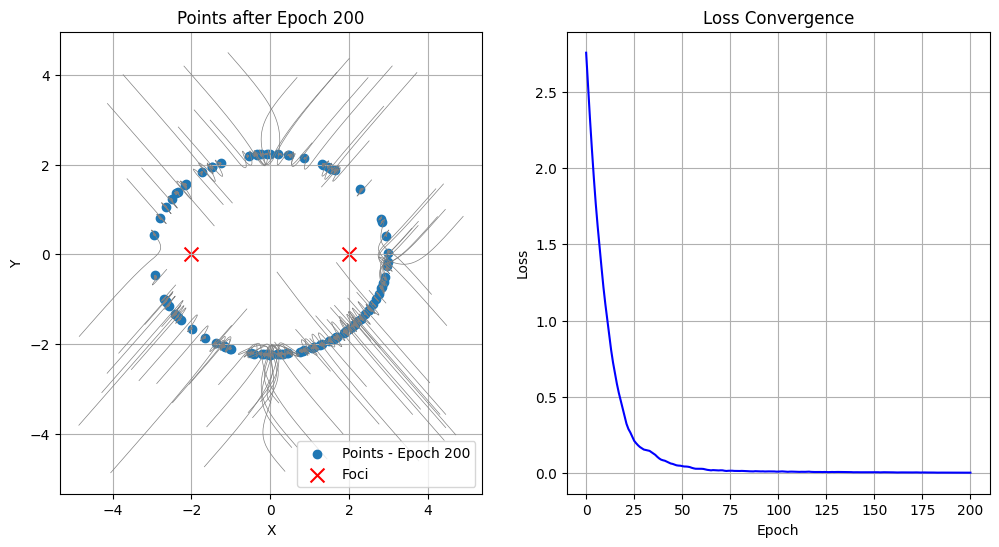

Epoch 200: Loss = 0.003128
Epoch 300: Loss = 0.001059


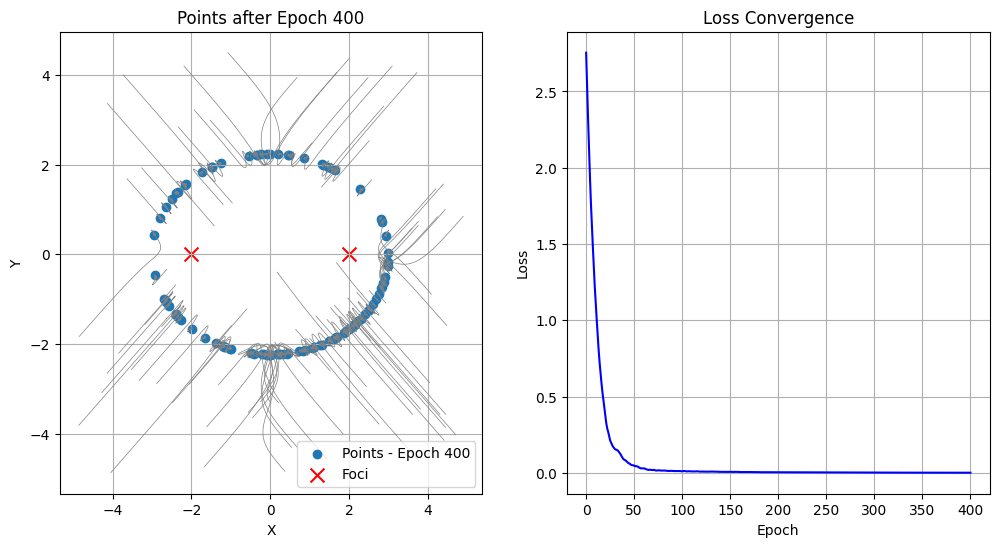

Epoch 400: Loss = 0.000411
Epoch 500: Loss = 0.000170


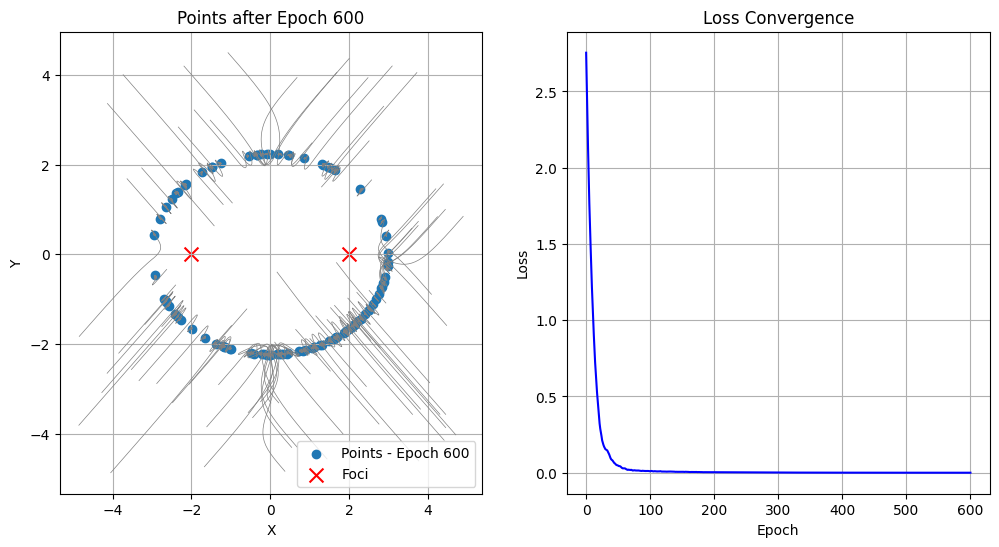

Epoch 600: Loss = 0.000051
Epoch 700: Loss = 0.000018


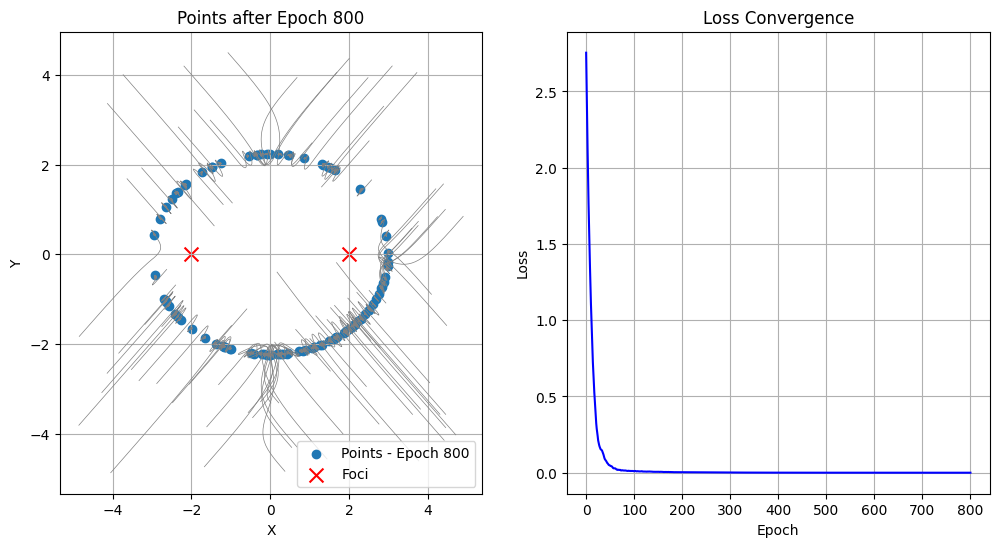

Epoch 800: Loss = 0.000007
Epoch 900: Loss = 0.000002
Elapsed time: 8.9950430393219 seconds


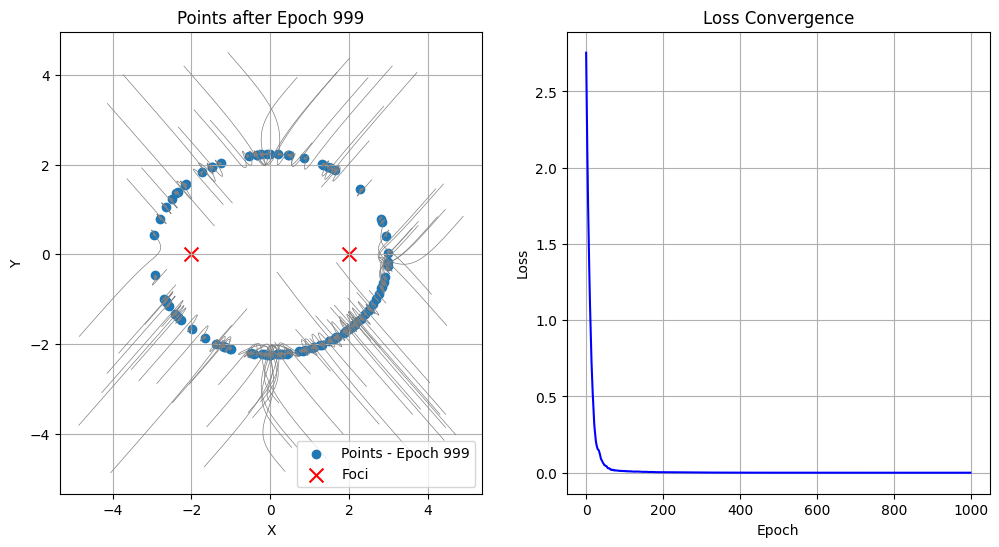

In [32]:
trajectories_L1_scheduler = train_with_loss(L1_loss, use_scheduler=True)

Conclusion:
With decaying learning rate, we achieved much better convergence:
$0.02\mapsto0.000002$

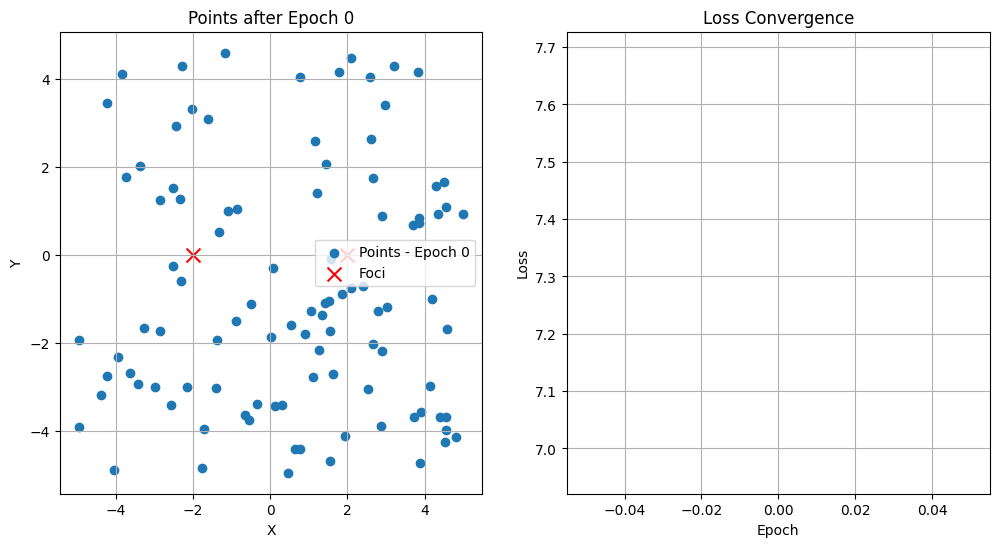

Epoch 0: Loss = 7.323938
Epoch 100: Loss = 2.393175


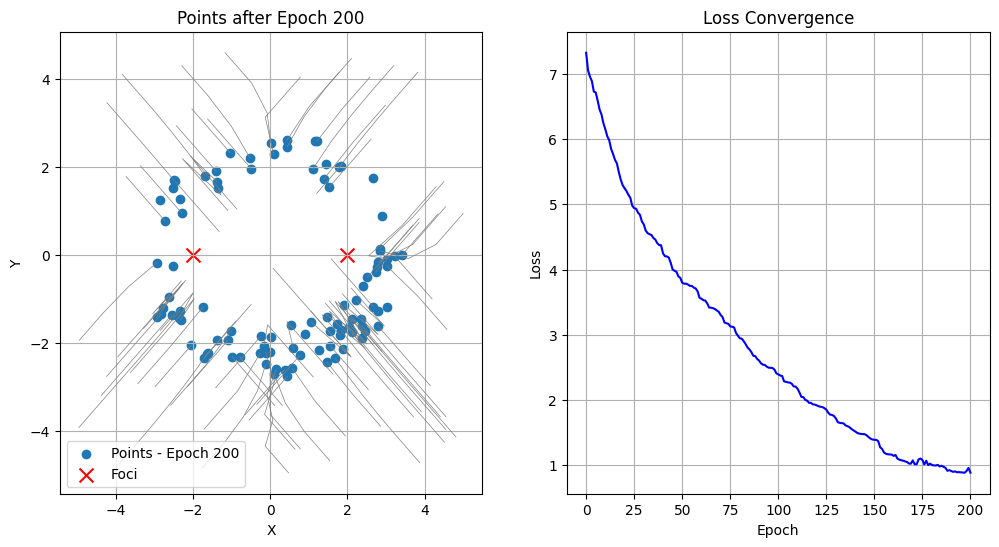

Epoch 200: Loss = 0.886059
Epoch 300: Loss = 0.537400


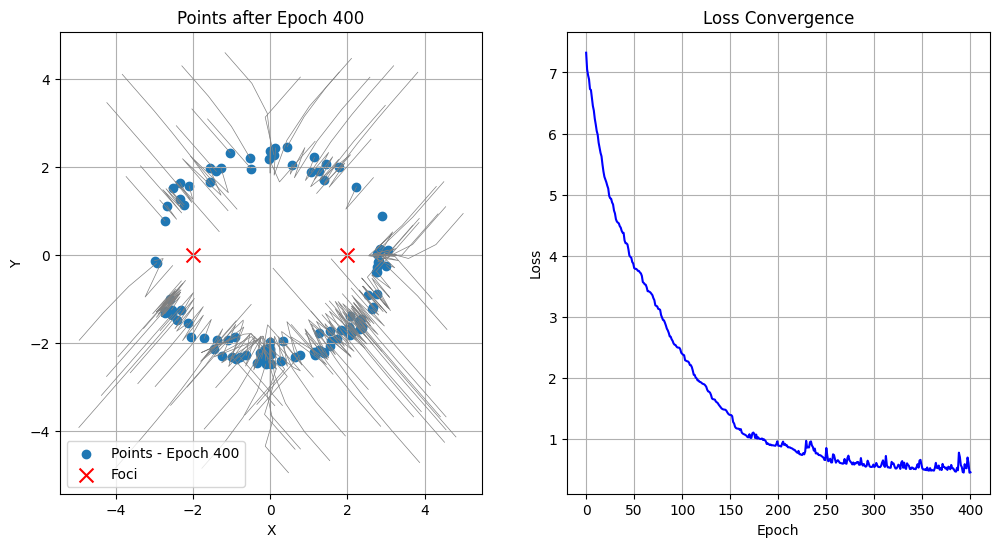

Epoch 400: Loss = 0.450675
Epoch 500: Loss = 0.422950


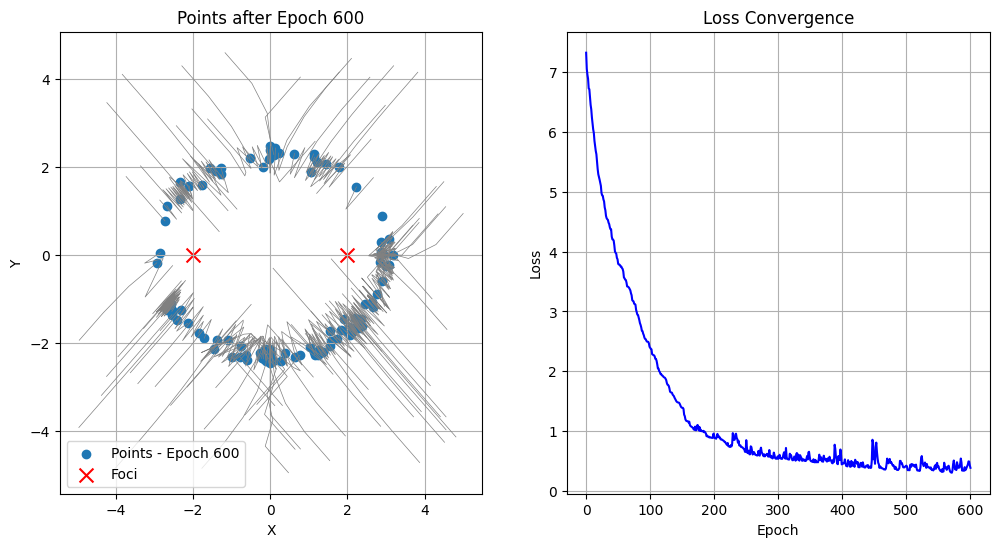

Epoch 600: Loss = 0.386728
Epoch 700: Loss = 0.477612


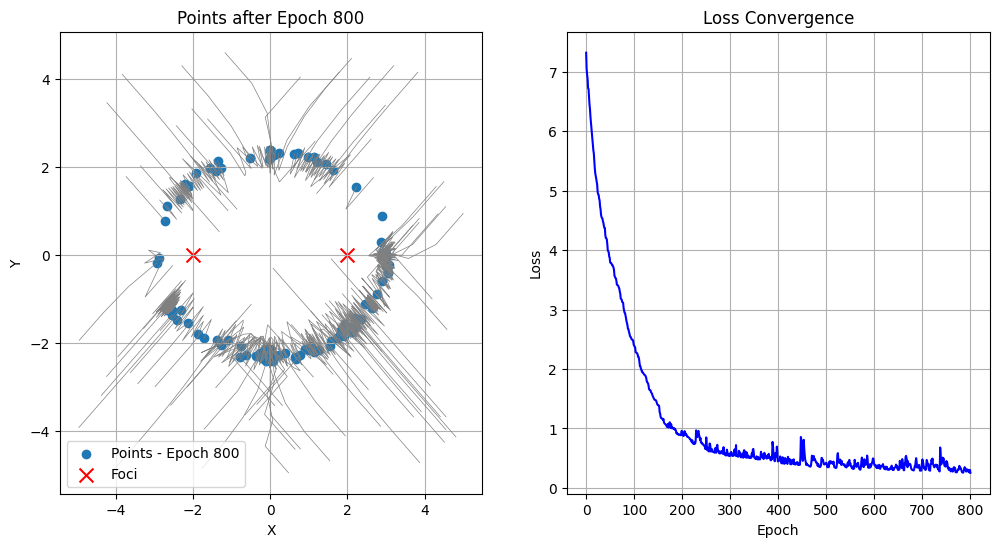

Epoch 800: Loss = 0.254017
Epoch 900: Loss = 0.257052
Elapsed time: 10.21769118309021 seconds


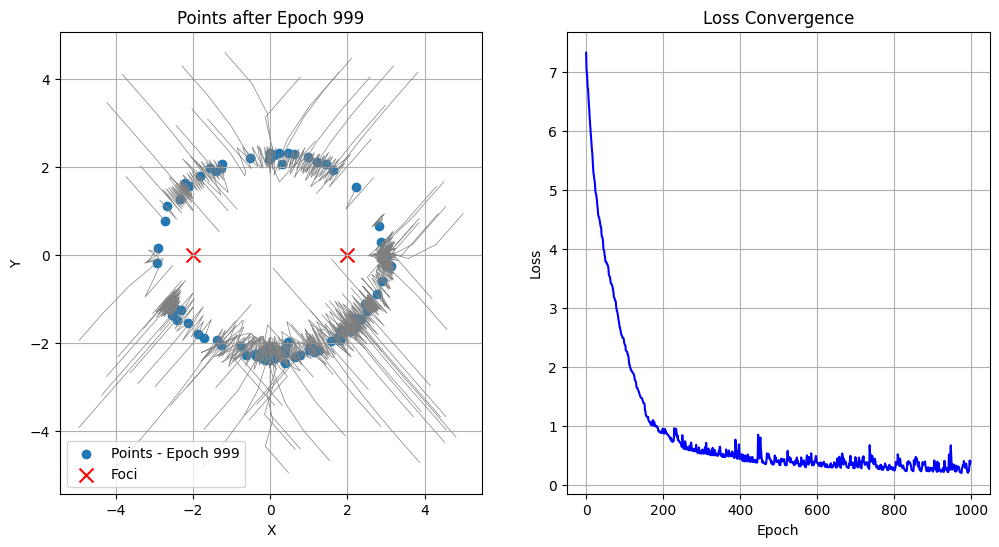

In [33]:
trajectories_L_infty = train_with_loss(L_infty_loss)

An ellipse is being drawn, but:
- we have bad convergence
- the training is slightly slower
- The ellipse is somewhat less accurate

Possible explanation: when taking the gradient of $\max |\epsilon_i|$, we get nonzero value only for the farthest point, and only this point will move

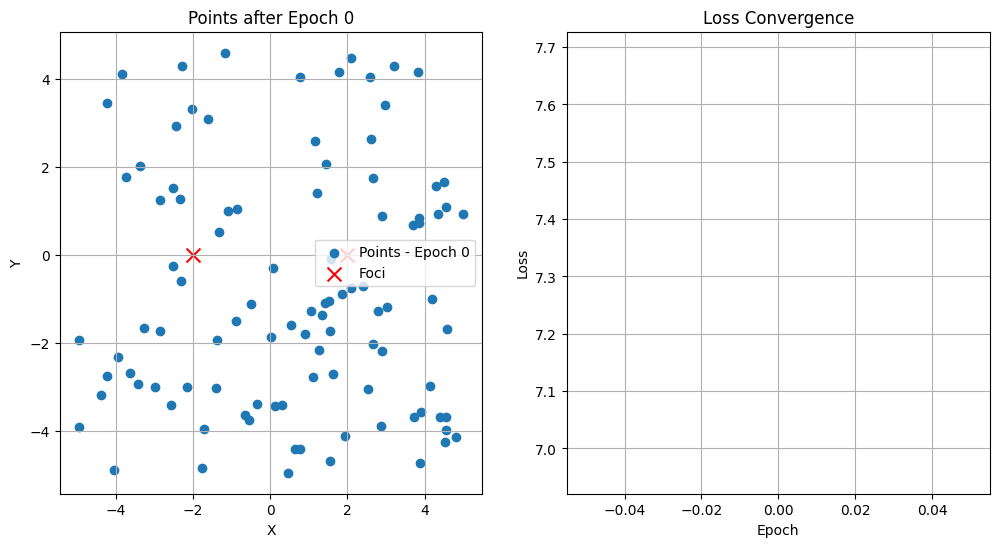

Epoch 0: Loss = 7.323938
Elapsed time: 1.2093098163604736 seconds


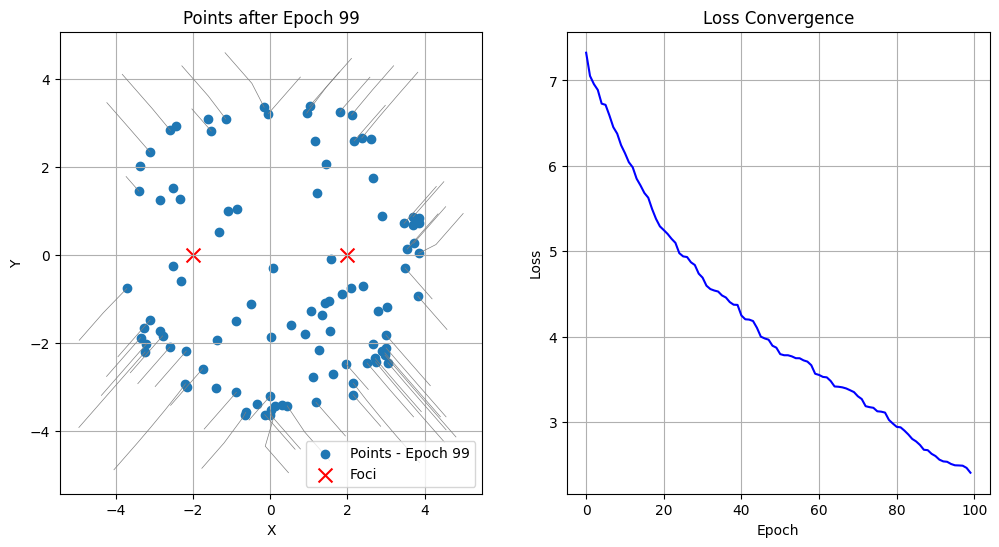

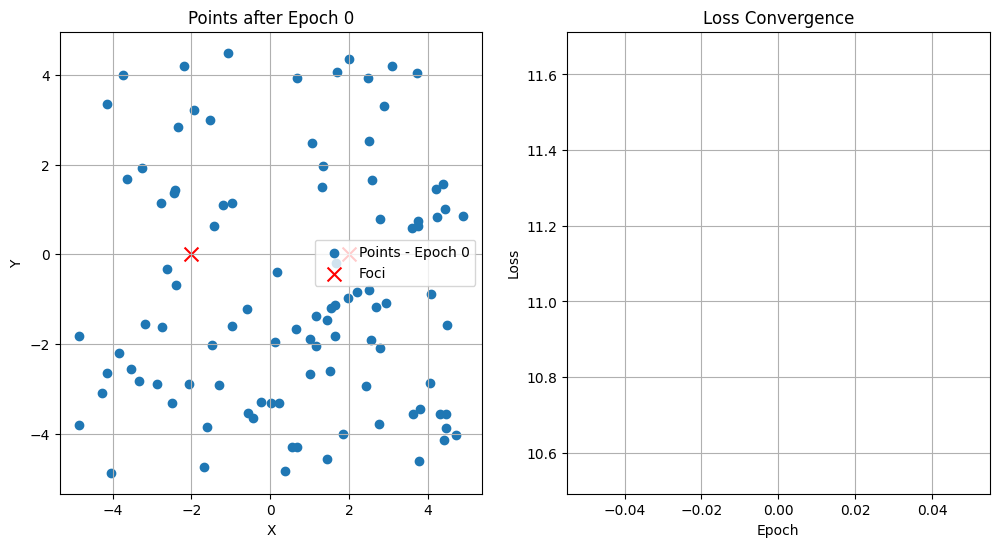

Epoch 0: Loss = 11.102330
Elapsed time: 0.995187520980835 seconds


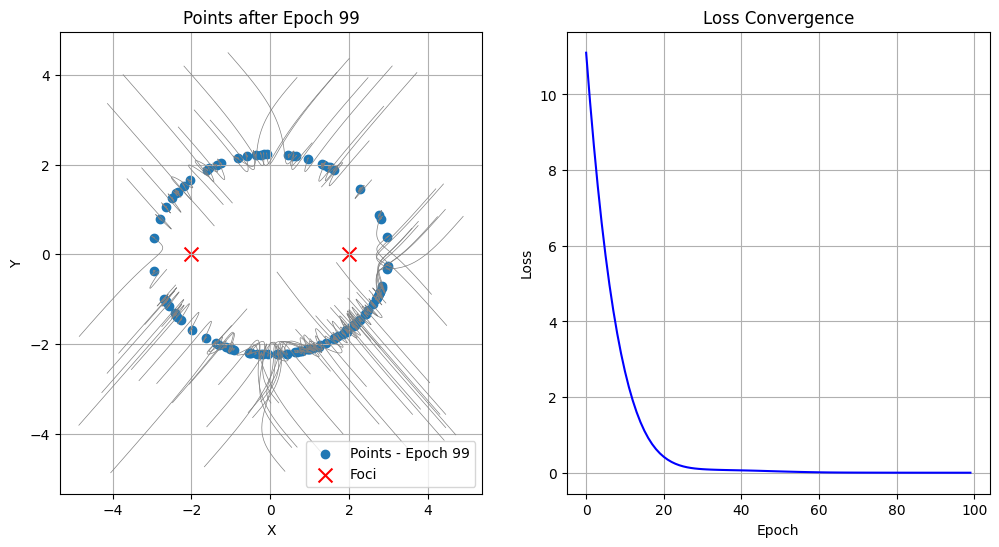

In [34]:
# Let's compare L_2 with L_infty for smaller number of epochs:

trajectories_L_infty_100_epochs = train_with_loss(L_infty_loss, num_epochs=100)

trajectories_L2_100_epochs = train_with_loss(L2_loss, num_epochs = 100)

conclusion:
Indeed, $L^{(\infty)}_\text{ellipse}$ only moves the farthest point. Moreover, the gradient is constant ($\pm1$), so the point doesn't move much and also the loss won't converge without learning rate decay.

Let's create some animated visualizations:

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

num_animations = 4

descriptions = {0: "L_2 loss", 1: "L_1 loss", 2: "L_1 loss with scheduler", 3: "L_infty loss"}

# print(type(trajectories_L1[0][0]))

compression = 10

fig, axes = plt.subplots(1, num_animations, figsize=(24, 6))

# We will need to reformat trajectories to valid frames:
def reformat_trajectories(trajectories, epochs = 1000):
    result = []
    for epoch in range(epochs):
        if (epoch % compression != 0): continue

        result.append([])
        for point_history in trajectories:
            result[-1].append(point_history[epoch])

        result[-1] = np.array(result[-1])

    return result


frames_L1 = reformat_trajectories(trajectories_L1)
frames_L1_scheduler = reformat_trajectories(trajectories_L1_scheduler)
frames_L2 = reformat_trajectories(trajectories_L2)
frames_L_infty = reformat_trajectories(trajectories_L_infty)

frames_all = list(zip(frames_L2, frames_L1, frames_L1_scheduler, frames_L_infty))

def animate(frame):
    animate.epoch += compression
    # update the plots:
    for k in range(num_animations):
        axes[k].clear()
        axes[k].set_title(f"{descriptions[k]} epoch {animate.epoch}")
        all_points_array = frame[k]
        # all_points_array = np.array(all_points)
        # print(all_points_array.shape)
        axes[k].scatter(all_points_array[:, 0], all_points_array[:, 1], label=f'Points - Epoch {animate.epoch}')
    return

animate.epoch = 0

print(frames_all[0][0].shape)

anim = FuncAnimation(fig, animate, frames=frames_all, blit=False, interval=240)
plt.close(fig)

# takes approx 40s.
HTML(anim.to_html5_video())


(100, 2)


Looking at the animations, we can confirm our guesses:

1. L_1 without scheduler is wobbly, which suggests overshooting the minimum

2. For L_infty, only a couple points each frame actually move (those are the farthest from foci)